In [51]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import xarray as xr

In [59]:
#### Define time window, sampling interval, and a few metadata ####
time = np.arange(100,180.1,0.1)
Nt = len(time)
path = '/projects/DEIKE/jiarongw/multilayer/JFM/field_new_200m_P0.008_RE40000_10_15_rand2_Htheta0.503/' # Change to config 
N = 1024 # Change to config  
L0 = 200 # Change to config

#### Read in 2D fields ####
fieldnames = ['eta','ux','uy']
fields = []
for fieldname in fieldnames:
    f_series = np.zeros((Nt,N,N), dtype=np.float32)
    for i in range(0, Nt):
        filename = path + f'surface/{fieldname}_matrix_%g' %time[i]
        f = np.fromfile(filename, dtype=np.float32)
        f = f.reshape(N+1,N+1); f = f[1:,1:]
        f_series[i] = f  
    fields.append(f_series)    
    
x_mesh = np.linspace(-L0/2, L0/2, N+1, endpoint=True)
ds = xr.Dataset(data_vars={name: (['t','x','y'], array) for name, array in zip(fieldnames, fields)},
                coords={'t': (['t'], time),
                        'x': (['x'], 0.5*(x_mesh[:-1]+x_mesh[1:])),
                        'y': (['y'], 0.5*(x_mesh[:-1]+x_mesh[1:]))},)
                # attrs=dict(sourcepath=field_path, **config))

In [60]:
#### Read in energy and interpolate onto surface field time ####
energy = pd.read_table(path +'energy_after_remap.dat', delimiter=' ', names=['t','ke','gpe'])
energy = energy.drop_duplicates(subset=['t'])
df = energy.set_index('t'); ds_energy = df.to_xarray()
ds['ke'] = ds_energy.ke.interp(t=ds.t)
ds['gpe'] = ds_energy.gpe.interp(t=ds.t)

In [61]:
filename = './series.nc'
encoding = {}
for var_name in ds.data_vars:
    encoding[var_name] = {'dtype': 'float32', 'zlib': True}
ds.to_netcdf(filename, encoding=encoding)

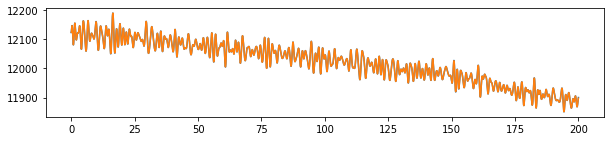

In [41]:
# energy = pd.read_table(path +'energy_after_remap.dat', delimiter=' ', names=['t','ke','gpe'])
# energy = energy.drop_duplicates(subset=['t'])
# df = energy.set_index('t'); ds = df.to_xarray()
# Bin average
# bins = np.arange(0, 200.1, 0.1) # Bin edges
# ds_resampled = ds.groupby_bins('t', bins=bins).mean()
# Or interpolate
# bins_c = np.arange(0, 200., 0.1) + 0.05  # Bin center
# ds_interped = ds.interp(t=bins_c)
fig = plt.figure(figsize=[10,2])
plt.plot(ds.t, ds.ke)
plt.plot(bins[:-1], ds_resampled.ke)
plt.plot(bins_c, ds_interped.ke)

In [65]:
ds_new = xr.open_dataset('/projects/DEIKE/jiarongw/multilayer/JPO/processed/C1/series.nc')

In [66]:
ds_new

<xarray.Dataset> Size: 10GB
Dimensions:  (t: 801, x: 1024, y: 1024)
Coordinates:
  * t        (t) float64 6kB 100.0 100.1 100.2 100.3 ... 179.7 179.8 179.9 180.0
  * x        (x) float64 8kB -99.9 -99.71 -99.51 -99.32 ... 99.51 99.71 99.9
  * y        (y) float64 8kB -99.9 -99.71 -99.51 -99.32 ... 99.51 99.71 99.9
Data variables:
    eta      (t, x, y) float32 3GB ...
    ux       (t, x, y) float32 3GB ...
    uy       (t, x, y) float32 3GB ...
    ke       (t) float32 3kB ...
    gpe      (t) float32 3kB ...
Attributes:
    sourcepath:  /projects/DEIKE/jiarongw/multilayer/JFM/field_new_200m_P0.00...
    L:           200
    P:           0.008
    Re:          40000
    LEVEL:       10
    NL:          15
    rand:        2
    Htheta:      0.503
    H:           40.0
    label:       C1